# Enhancing Customer Insights in Wholesale Distribution

**Context**: The data set refers to clients of a wholesale distributor. It includes the annual spending in
monetary units on diverse product categories.

**Dataset Source**: "Wholesale customers data.csv"

**Task**: Goal of this project is to best describe the variation in the different types of customers that a
wholesale distributor interacts with.

**Implementation**:
- Perform EDA and any data cleaning if necessary.
- Implement Feature Scaling to Normalize the data(compare the histogram/KDE for MinMaxScaler
and StandardScaler). Choose one of the Scaler to proceed ahead and provide reasoning as to
why it was selected?
- Find optimal number of features using RFECV and show the plot between Number of features
selected vs Cross validation score (use channel as target variable)
- Implement KMeans Clustering for K=2 to K=15 and based on elbow method identify what is the
optimum number of clusters
- Implement PCA with number of original features to answer how much variance is explained by
first 2 components and by first 4 components and visualize the clusters in the data
- Implement XGBoost Classifier with 5 Fold CV and report the performance metrics

**Submission Instructions**: Please just submit one jupyter notebook containing all the code and make use
of markdown cells to include the comments, answers, reasoning, analysis, etc.

**Note: Name of your file should be your “Project2-id_Firstname_Lastname.ipynb”**

# Exploratory Data Analysis

## Reading the Data

In [1]:
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from time import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFECV
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import sys

%matplotlib inline

customers = pd.read_csv('wholesale customers data.csv')
customers.head(5)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


## Exploring the Data

Description of features is as folllows:

-    FRESH : annual spending (m.u.) on fresh products (Continuous);
-    MILK : annual spending (m.u.) on milk products (Continuous);
-    GROCERY : annual spending (m.u.)on grocery products (Continuous);
-    FROZEN : annual spending (m.u.)on frozen products (Continuous);
-    DETERGENTS_PAPER : annual spending (m.u.) on detergents and paper products (Continuous);
-    DELICATESSEN : annual spending (m.u.)on and delicatessen products (Continuous);
-    CHANNEL : customers Channel - Hotel (Hotel/Restaurant/Cafe) or Retail channel (Categorical);
-    REGION : customers Region Lisnon, Oporto or Other (Categorical);

As we can see from the two tables below and the information provided in [this link](https://archive.ics.uci.edu/ml/datasets/wholesale+customers) about the dataset, there are two nominal variables and the rest of the variables are continuous. The two nominal features are `Channel` which is our target variable in this case, and `Region`. 

In [2]:
customers.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


Our dataset looks like complete as there are total of 440 rows and all the features have 440 values in them, therefore, does not need handling of missing variables. Also, all the features are represented in type of `int64`, so there is no need for converting our categorical features into numerical values as it is already done.

In [3]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


The data frames below show that, there are 3 possible values `(1, 2, 3)` for `Region` and 2 possible values `(1, 2)` for `Channel` in the dataset. This is mentioned to have a better understanding of what our dataset presents.

\
REGION Frequency and their representing nominal values:

> Lisbon 77 ---> 1\
> Oporto 47 ---> 2\
> Other Region 316 ---> 3\
> Total 440

\
CHANNEL Frequency and their representing nominal values:


> Horeca 298 ---> 1\
> Retail 142 ---> 2\
> Total 440 

In [4]:
customers['Region'].value_counts()

3    316
1     77
2     47
Name: Region, dtype: int64

In [5]:
customers['Channel'].value_counts()

1    298
2    142
Name: Channel, dtype: int64

For the analysis on the data we convert the values we have in `Channel` to 0 and 1 as stated below:

> Horeca 298 ---> 1\
> Retail 142 ---> 0\
> Total 440

In [6]:
channel_map = {2: 0, 1: 1}

customers['Channel'] = customers['Channel'].map(channel_map)

## Plotting data

As we can see below there are clearly some outliers in our dataset which we need to handle as the outliers do not represent our actual dataset. Also there is no clear pattern between the features and the `Channel` feature which is our target variable.

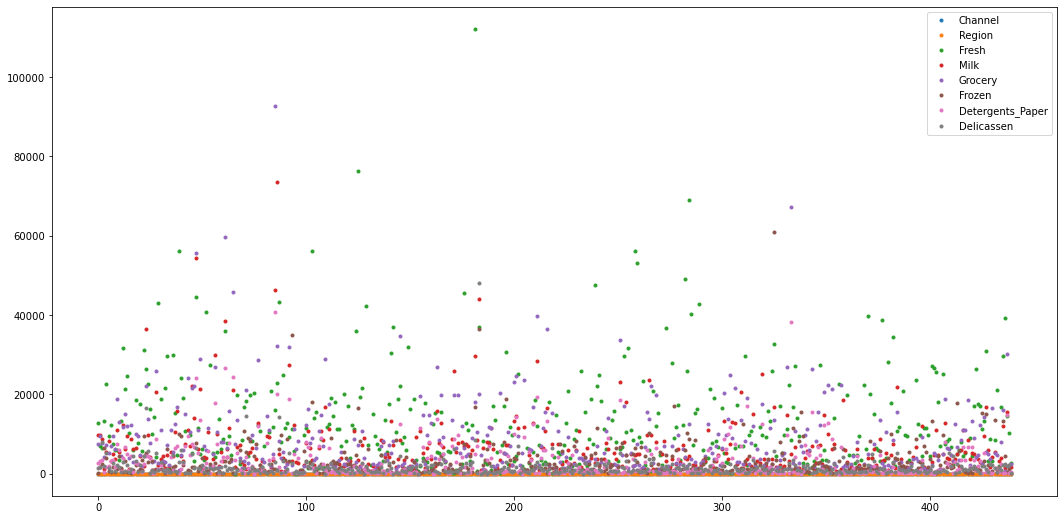

In [7]:
customers.plot(figsize=(18,9), style='.');

<AxesSubplot:>

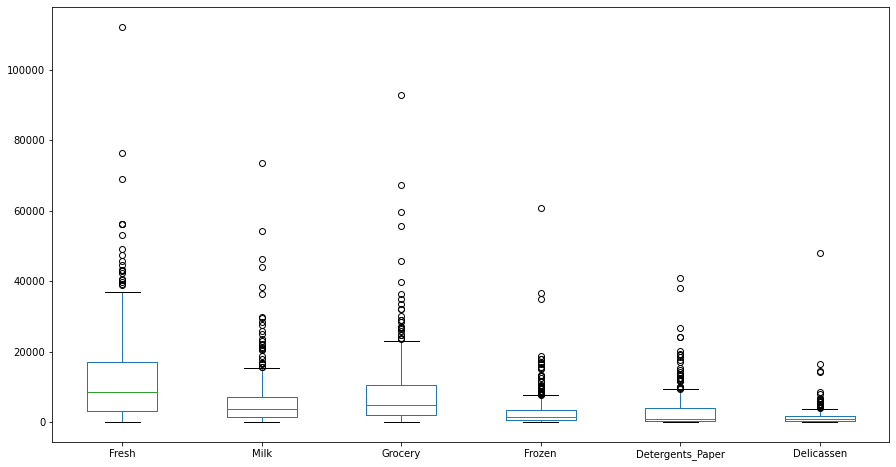

In [8]:
fig = plt.figure(figsize = (15,8))
customers_cont = customers.drop(['Channel', 'Region'], axis=1)
customers_cont.boxplot(grid=False)

**boxplot** considers **Q3 + 1.5 IQR** as its `upper bound` and **Q1 - 1.5 IQR**  as its `lower bound`. Anything greater than `upper bound` and smaller than `lower bound` would be considered as outlier and we delete them as the outliers might cause the models not to perform at their best.

In [9]:
df = customers.copy()

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# This part of the code is taken from StackOverflow
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

print("Number of outliers detected %d" % (len(customers) - len(df)))
print("Proportion of outliers to the whole dataset is %f" % ((len(customers) - len(df))/len(customers)))
    


Number of outliers detected 108
Proportion of outliers to the whole dataset is 0.245455


As the number of outliers detected in total are more than 20% of our dataset, then not dropping them would be more reasonable and we will try feature engineering to reduce the effects of the outliers.

<AxesSubplot:>

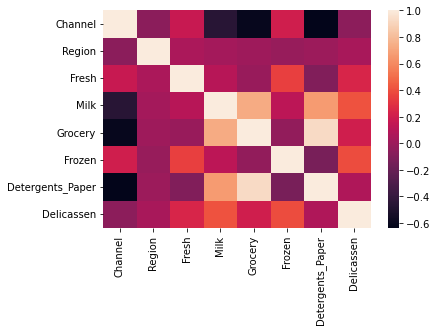

In [10]:
sns.heatmap(customers.corr())

As we can see from our correlation table the some of the independent features represent a hight correlation that needs to be resolved as high correlations between the independent variables result in multicollinearity and it may cause overfitting.

The other features that have high correlation between them are:
1. `Grocery` and `Detergents_Paper` have correlation of **0.924641**
2. `Grocery` and `Milk` have correlation of **0.728335**
3. `Milk` and `Detergents_Paper` have correlation of **0.661816**


In [11]:
(customers.corr()).style.background_gradient(cmap='coolwarm')

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,1.000000,-0.062028,0.169172,-0.460720,-0.608792,0.202046,-0.636026,-0.056011
Region,-0.062028,1.000000,0.055287,0.032288,0.007696,-0.021044,-0.001483,0.045212
Fresh,0.169172,0.055287,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,-0.460720,0.032288,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.608792,0.007696,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,0.202046,-0.021044,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,-0.636026,-0.001483,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,-0.056011,0.045212,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


Below is a complete plot of, plots of different features of the dataset. As it can be seen from below, the attributes overlap most of the time but, for example, `Fresh` vs `Detergents_Paper` plot, they are some what distinctable. Based on the plots below we can say, our model will have a good chance of predicting the `Channel` of the wholesale customers correctly by taking into account different features at the same time.

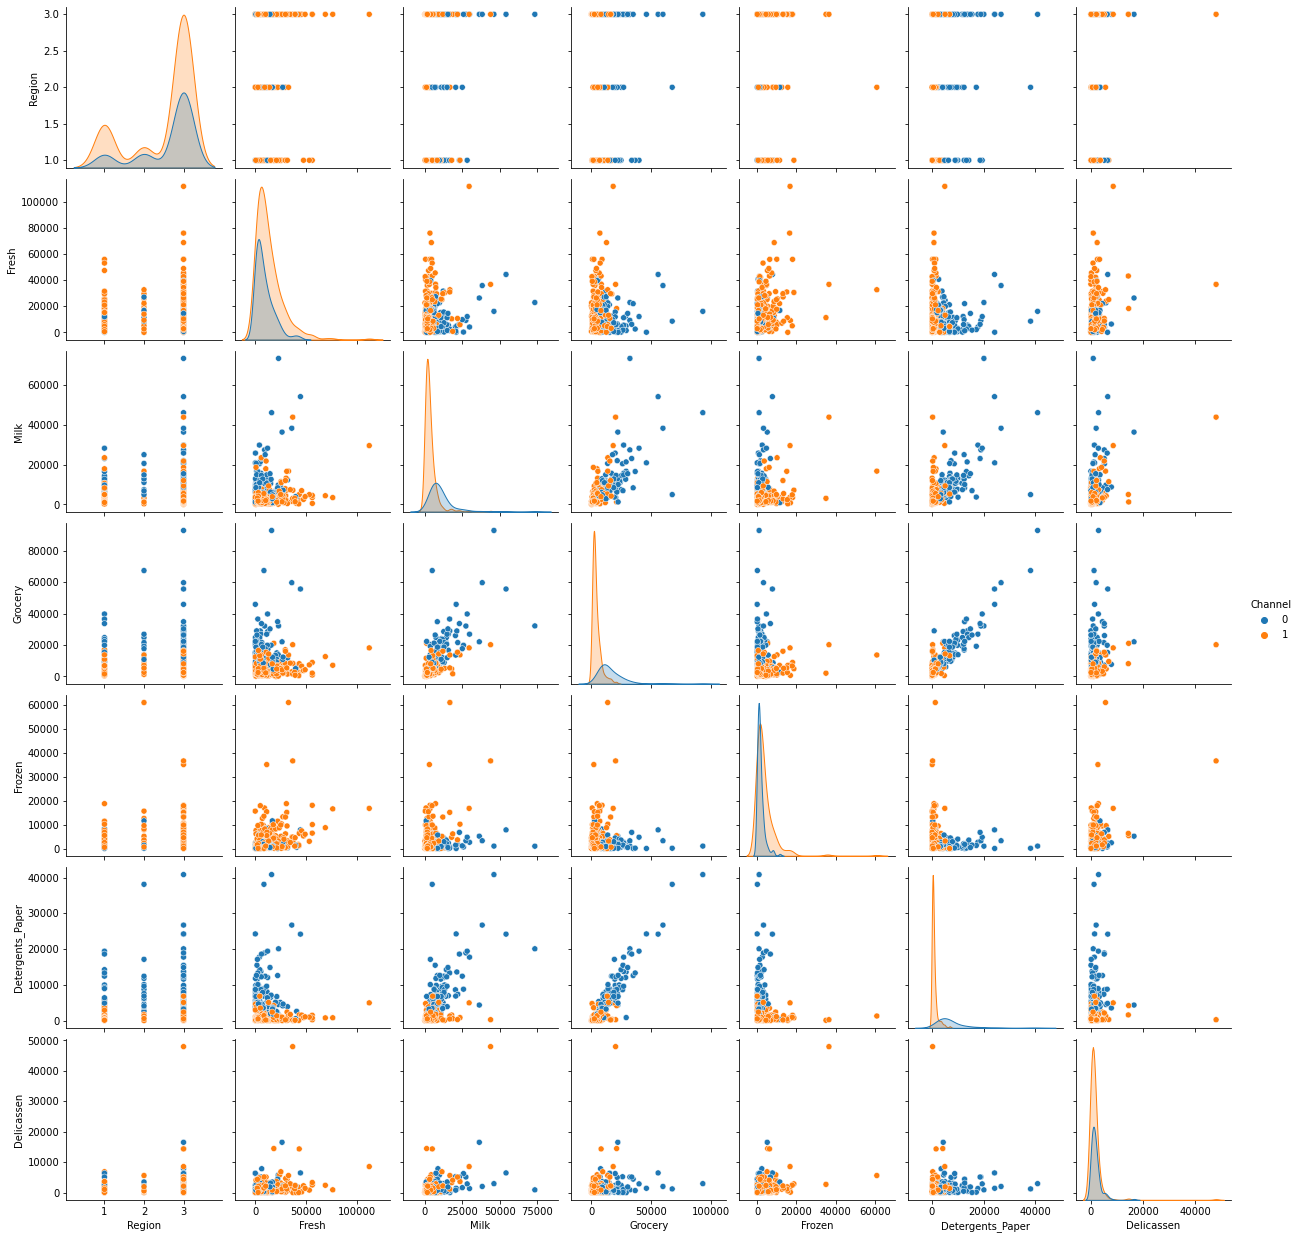

In [12]:
sns.pairplot(customers,hue="Channel")
plt.show()

The plots below give us additional insights around the dataset we have. The 6 plots below are the overlaid histograms for `Fresh`, `Milk`, `Grocery`, `Frozen`, `Detergents_Paper`, `Delicassen`. The histograms show the distribution for the two `Channel` based on their `Grocery` value, for example. As we can see from the below plots, most of the purchases in both `Channel`s have low values and there are only some with high values. The Overlaid histograms show that the `Retail (Channel 0)` has mostly bigger values compared to `Horeca (Channel 1)` but they also overlap most of them time.

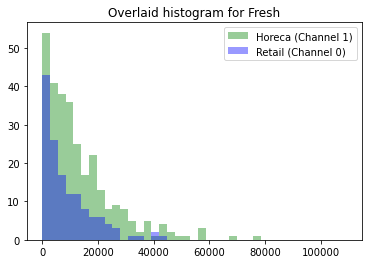

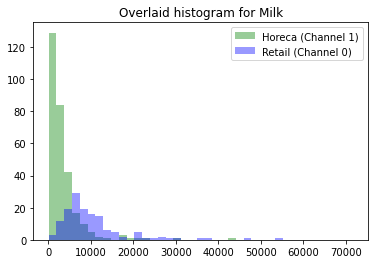

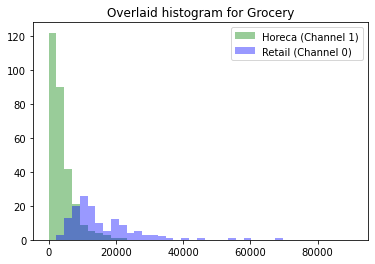

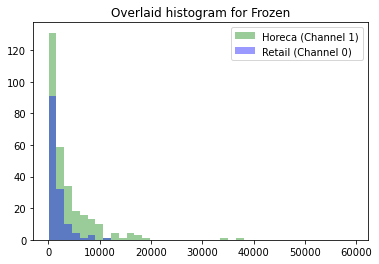

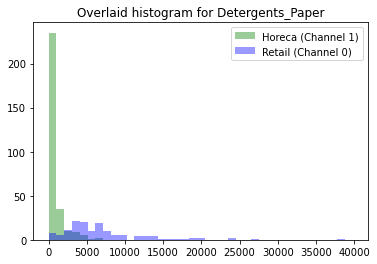

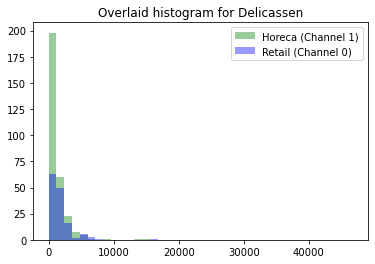

In [13]:
for i in ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']:
    channel1 = list(customers[customers['Channel'] == 1][i])
    channel0 = list(customers[customers['Channel'] == 0][i])
    xmin = min(min(channel1), min(channel0))
    xmax = max(max(channel1), max(channel0))
    width = (xmax - xmin) / 40
    sns.distplot(channel1, color='g', kde=False, bins=np.arange(xmin, xmax, width))
    sns.distplot(channel0, color='b', kde=False, bins=np.arange(xmin, xmax, width))
    plt.legend(['Horeca (Channel 1)', 'Retail (Channel 0)'])
    plt.title('Overlaid histogram for {}'.format(i))
    plt.show()

# Feature Scaling

Feature Scaling converts our original data to a scalable version of it in a way that features do not lose their values and each one of the features have same importance as the rest of the features. Some of the data in our dataset have larger values than others so by using feature scaling we try to eliminate any effects that would cause from the magnitude of values.

We implement both `Standard Scalar Method` and `MinMax Scalar Method` to see which one performs better on our dataset and apply it.

<AxesSubplot:ylabel='Density'>

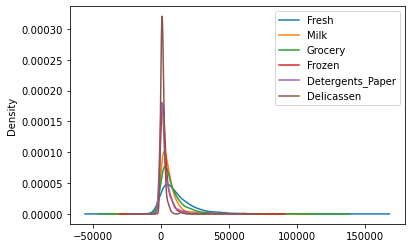

In [14]:
customers.drop(['Channel', 'Region'], axis=1).plot(kind='kde')

<AxesSubplot:ylabel='Frequency'>

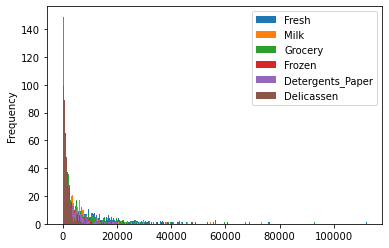

In [15]:
customers.drop(['Channel', 'Region'], axis=1).plot(kind='hist', bins=300)

## Standard Scalar Method

Standard Scalar Method basically changes the values of data in our dataset to have mean value of 0 and standard deviation of 1. The formula used to achieve this goal is `y = (x-mean)/std`

In [16]:
# First we make a copy of our dataset so we would not accidentally change our original dataset
# Also we only scale the features which are continuous
df1 = customers.drop(['Channel', 'Region'], axis=1)

standardScale = StandardScaler().fit_transform(df1)

standardScale_df = pd.DataFrame(standardScale, columns=df1.columns)

standardScale_df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339
1,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151
2,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293
3,0.100111,-0.624020,-0.392977,0.687144,-0.498588,0.093411
4,0.840239,-0.052396,-0.079356,0.173859,-0.231918,1.299347


<AxesSubplot:ylabel='Density'>

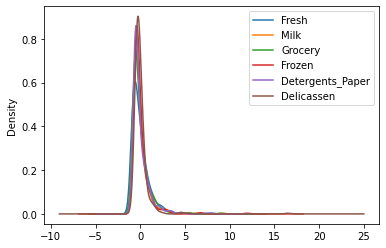

In [17]:
standardScale_df.plot(kind='kde')

<AxesSubplot:ylabel='Frequency'>

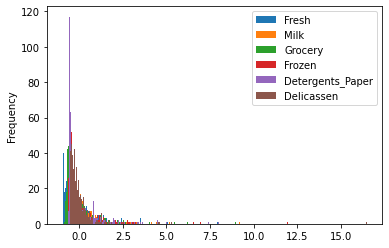

In [18]:
standardScale_df.plot(kind='hist', bins=300)

The Standard Scalar Method did a pretty good job with feature scaling as can be seen clearly from the `kde` plot. It has converted the data we originally had to a dataset where all the data have almost the same range as other features and this would make the prediction easier for the models.

## MinMax Scalar Method

MinMax Scalar Method changes the data in our dataset to be in range of [0,1] by using the normalization formula: `y = (x-min)/(max-min)`

In [19]:
# First we make a copy of our dataset so we would not accidentally change our original dataset
# Also we only scale the features which are continuous
df2 = customers.drop(['Channel', 'Region'], axis=1)

minMaxScale = MinMaxScaler().fit_transform(df2)

minMaxScale_df = pd.DataFrame(minMaxScale,columns=df2.columns)

minMaxScale_df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.112940,0.130727,0.081464,0.003106,0.065427,0.027847
1,0.062899,0.132824,0.103097,0.028548,0.080590,0.036984
2,0.056622,0.119181,0.082790,0.039116,0.086052,0.163559
3,0.118254,0.015536,0.045464,0.104842,0.012346,0.037234
4,0.201626,0.072914,0.077552,0.063934,0.043455,0.108093


<AxesSubplot:ylabel='Density'>

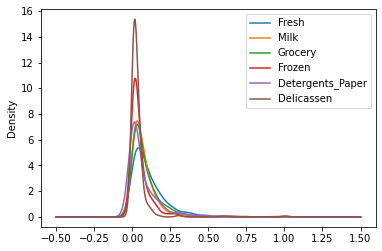

In [20]:
minMaxScale_df.plot(kind='kde')

<AxesSubplot:ylabel='Frequency'>

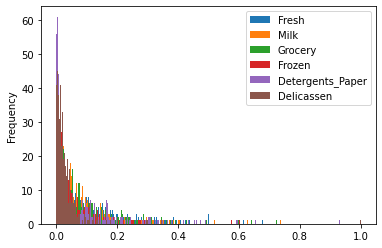

In [21]:
minMaxScale_df.plot(kind='hist', bins=300)

The MinMax Scalar Method also did pretty well with feature scaling as can be seen clearly from the plots above. It has converted the data we originally had to a dataset where all the data have the range of [0,1] as other features and this would make the prediction easier for the models.

## Comparison Between the Standard and MinMax Scalar Methods

As it can be seen from the graphs, both of the Standard and MinMax Scalar methods did well with scaling the data but Standard Scalar Method did better. By looking at the `kde` graphs, we can see that the density of different features in the scaled version using MinMax Scalar Method differs more than the densities in scaled version using Standard Scalar Method which could cause the model to have biased prediction. For this reason we choose Standard Scalar Method to as our Feature Scaling method.

In [22]:
scaledDf = standardScale_df

# RFECV

We use the scaled features which we obtained by feature engineering for the RFECV. To use it, the `Region` has to be added to our X values and consider `Channel` as our target variable.

In [23]:
scaledDf['Region'] = customers['Region']
X = scaledDf
y = customers['Channel']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

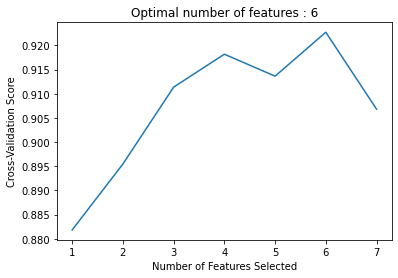

The features are as follows:  ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']


In [24]:
rfecv = RFECV(estimator=RandomForestClassifier())
rfecv.fit(X, y)

# Plot number of features VS. cross-validation scores
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validation Score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.title("Optimal number of features : %d" % rfecv.n_features_)
plt.show()

print("The features are as follows: ", scaledDf.columns[rfecv.support_].tolist())

As we can see in the above cell, the optimal number of features is 6 and the features are `Fresh`, `Milk`, `Grocery`, `Frozen`, `Detergents_Paper`, and `Delicassen`.

# KMeans Clustering

For this part we first implement the KMeans Clustering for K=2 to K=15 and then by using the elbow method we identify the optimum number of clusters.

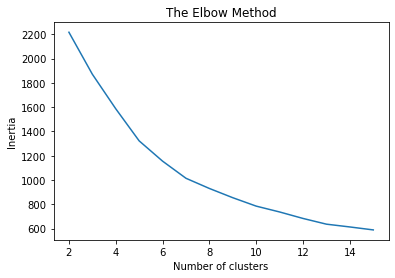

In [25]:
inertias = []
for i in range(2, 16):
    kmeans = KMeans(n_clusters = i, random_state = 7)
    kmeans.fit(scaledDf)
    inertias.append(kmeans.inertia_)
    cluster_labels = kmeans.labels_
plt.plot(range(2, 16), inertias)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

By using Elbow Method, the optimum number of clusters would be 7.

In [26]:
kmeans = KMeans(n_clusters = 7,random_state = 7).fit(scaledDf)
print("Inertia: ", kmeans.inertia_)
print("The centroids coordinates are as follows: ")
for i in range(0,7):
    print("\tCentroid number %d: " % (i+1), end='\n\t')
    print(kmeans.cluster_centers_[i], end='\n\n')

Inertia:  1014.3680859892069
The centroids coordinates are as follows: 
	Centroid number 1: 
	[-0.22769812 -0.34582446 -0.41720485 -0.1187089  -0.38413343 -0.1790934
  3.        ]

	Centroid number 2: 
	[ 3.13830315e-01  3.92190593e+00  4.27561037e+00 -3.57419457e-03
  4.61816580e+00  5.03365339e-01  2.50000000e+00]

	Centroid number 3: 
	[-0.52725414  0.67712364  0.97454794 -0.34250796  0.98535368  0.0439009
  2.58139535]

	Centroid number 4: 
	[ 2.04769049  0.03613408 -0.12935913  0.61566275 -0.34062888  0.54486783
  2.75      ]

	Centroid number 5: 
	[ 1.96681731  5.17550306  1.28721685  6.90059988 -0.55486198 16.47844745
  3.        ]

	Centroid number 6: 
	[-0.14815235 -0.39254844 -0.41025632 -0.01403913 -0.39017655 -0.18845515
  1.34831461]

	Centroid number 7: 
	[ 0.79278421  0.56168505 -0.01130144  9.25255676 -0.46404706  0.93316414
  2.5       ]



# PCA

In this section we calculate the variance explained by the first 2 components and by the first 4 components in PCA and visualize the clusters in the data using PCA. 

First two components in PCA:

In [27]:
pca2 = PCA(n_components=2).fit(scaledDf)
pca2df = pca2.transform(scaledDf)

print("Explained variance by the first 2 components:", pca2.explained_variance_)
print("Explained variance ratio by the first 2 components:", pca2.explained_variance_ratio_)
print(pca2df.shape)

Explained variance by the first 2 components: [2.65133312 1.70737774]
Explained variance ratio by the first 2 components: [0.40091742 0.2581786 ]
(440, 2)


As we can see above, the explained variance ratio for first component is 40.09% and for the second component is 25.82%.

First four components in PCA:

In [28]:
pca4 = PCA(n_components=4).fit(scaledDf)
pca4df = pca4.transform(scaledDf)

print("Explained variance by the first 4 components:", pca4.explained_variance_)
print("Explained variance ratio by the first 4 components:", pca4.explained_variance_ratio_)

Explained variance by the first 4 components: [2.65133312 1.70737774 0.74423478 0.62656443]
Explained variance ratio by the first 4 components: [0.40091742 0.2581786  0.11253836 0.09474501]


As we can see above, the explained variance ratio for first component is 40.09%, second component is 25.82%, third component is 11.25%, and fourth component is 9.47%.

The visualization of clusters using first two components of PCA would be as follow (we cannot show the plot of clusters using first four components of PCA as it would need four dimensions which is not possible to visualize):

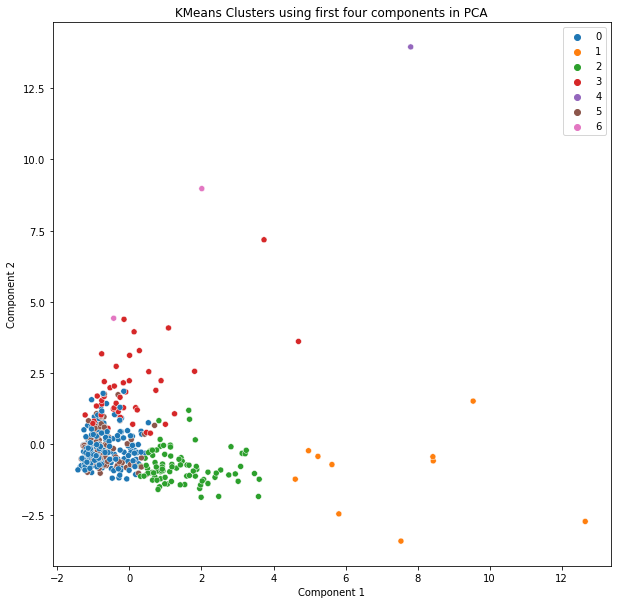

In [29]:
plt.figure(figsize = (10,10))
sns.scatterplot(pca4df[:,0], pca4df[:,1], 
                hue=kmeans.labels_, 
                palette="tab10")
plt.title("KMeans Clusters using first four components in PCA")
plt.legend()
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

As we can see from the above table the only clusters that are obvious that they are seperated are `cluster 1` which is represented by `orange` color, and `cluster 4` which is represented by `purple` color. The rest of the clusters shown are also seperated but cannot be visually seen in graph. 

# XGBoost Classifier

There are generally two ways to test the performance of a Gradient Boosting model. One is to explicitly indicate the train and test sets so that the model can be trained on the train model and be tested on the test set which will give us the scores of its performance. The other one is to use K-Fold CV which splits the data into `K` parts and then the system trains the model on `K-1` of those folds and finally would test the model on one fold. The system does this for `K` times and gives its average performance scores. For this section we will use `K-Fold CV` to test the performance of our model. Finally, when we have the results of our model we calculate the precision, recall, and accuracy scores to see how well the model performed.

In order to use XGBoost Classifier, first the package has to be installed which can be done by the following command. In this section we used [this link](https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/) as a reference. 

In [30]:
# !pip install xgboost

In [31]:
from xgboost import XGBClassifier

In [32]:
XNonscaled = customers.drop(['Channel'], axis=1)
yNonscaled = customers['Channel']

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score)}

model = XGBClassifier(eval_metric='mlogloss')
kfold = KFold(n_splits=5)
results = cross_validate(model, XNonscaled, yNonscaled, cv=kfold, scoring=scoring)

accuracy = results['test_accuracy'].mean()*100
precision = results['test_precision'].mean()*100
recall = results['test_recall'].mean()*100

print("Performance Scores: \n\tAccuracy: %f\tPrecision: %f\tRecall: %f" % (accuracy, precision, recall))

Performance Scores: 
	Accuracy: 91.136364	Precision: 93.260274	Recall: 92.966809
